 Fs=1000 hz
 Ts=0.001 s
[ 0.00324684  0.00963466  0.00644075 ... -0.0063349  -0.02230445
 -0.03188618]
 Fs=46950 hz
 Ts=0.001 s


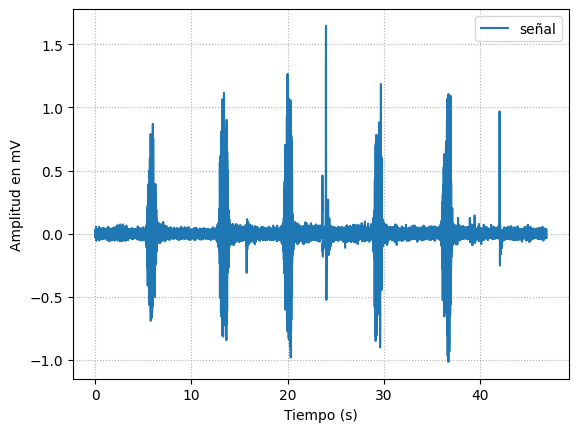

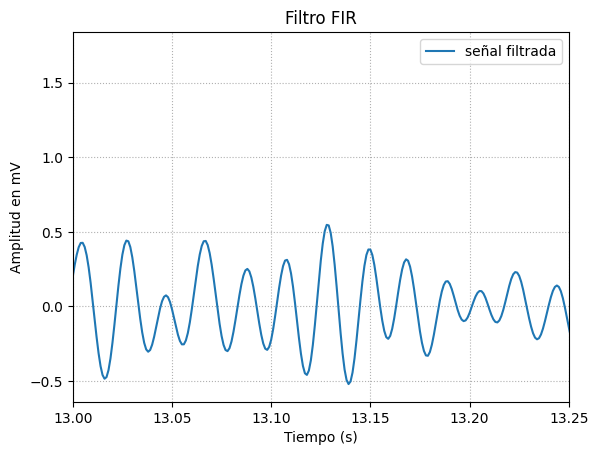

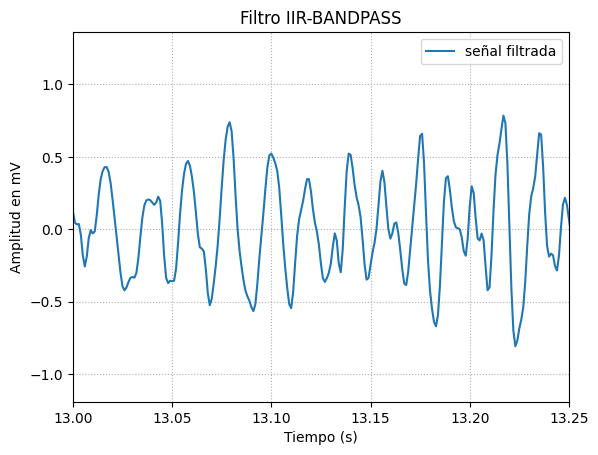

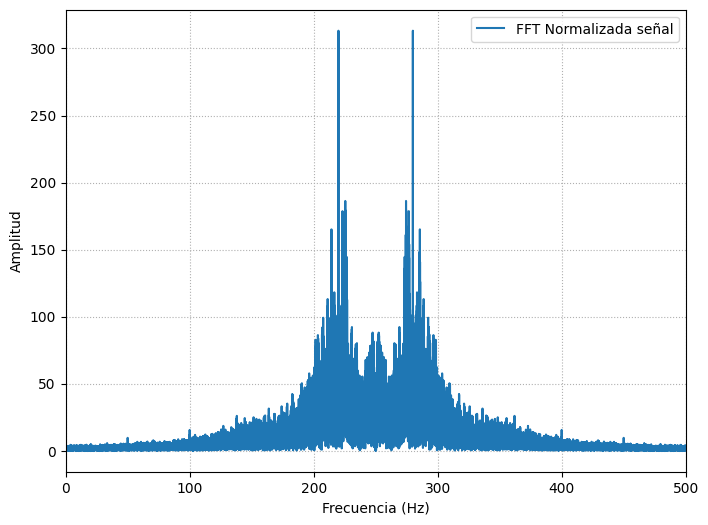

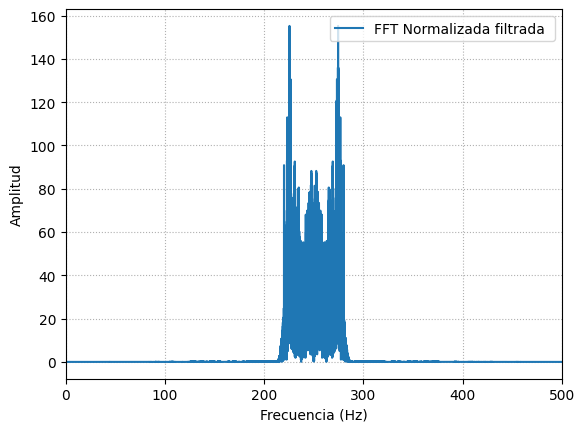

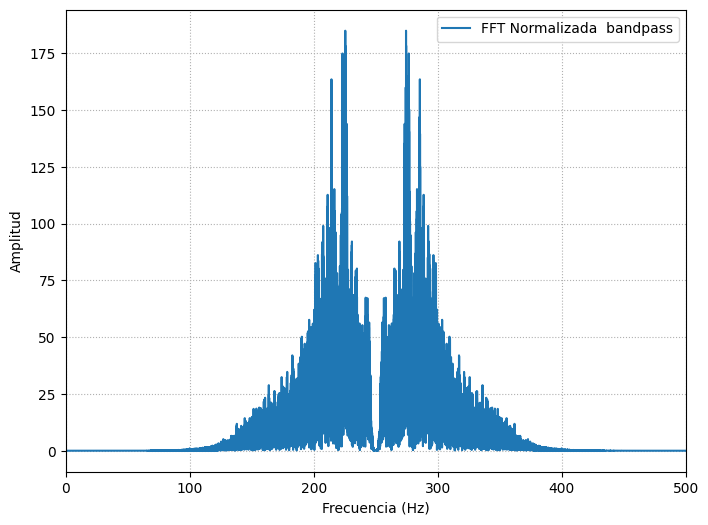

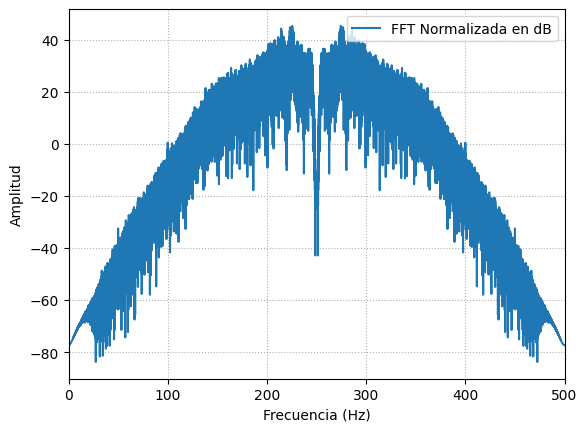

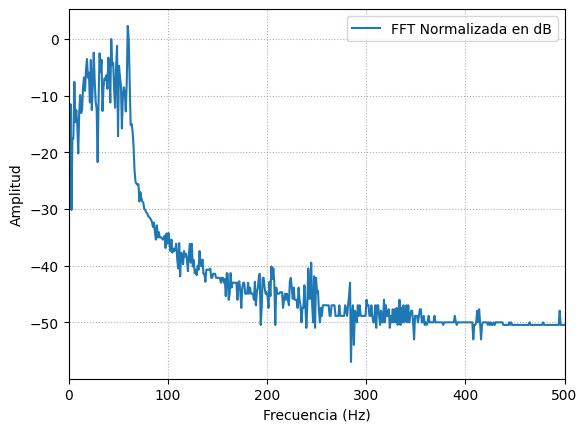

{'media': 1.9059419762468076e-18,
 'desviacion_estándar': 0.1037660769829512,
 'amplitud': 2.6605279051040633,
 'duration of muscular contraccion': 0.9998935037273695,
 'frecuencia dominante': 44133,
 'potencia': 0.010767398732431755,
 'kurtosis': 43.03931909580141,
 'wavelet': array([ 4.49437397e-05, -3.19412071e-03, -1.08047692e-02, ...,
        -2.75554168e-02, -8.95167076e-02,  1.26079877e-02]),
 'rms': 0.1037660769829512,
 'area': array([0.00644075, 0.01447845, 0.02251615, ..., 0.05573467, 0.04141499,
        0.01431967]),
 'min_value': -1.015610788348157,
 'max_value': 1.6449171167559062,
 'area_freq': array([0.        , 0.00020211, 0.00054108, 0.0008268 , 0.00105408,
        0.00122879, 0.00135444, 0.00147938, 0.00165748, 0.00185704,
        0.0020771 , 0.00240802, 0.00295716, 0.00381163, 0.00475498,
        0.00548745, 0.00606099, 0.00659897, 0.00714717, 0.00766756,
        0.00806356, 0.00841288, 0.00877993, 0.00910239, 0.00942302,
        0.0097181 , 0.00990999, 0.01002221, 0

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import re
from scipy import integrate

from scipy.integrate import cumtrapz
from scipy.stats import linregress
from scipy.signal import firwin, lfilter,butter,iirnotch,find_peaks,filtfilt,hilbert,welch
from tqdm import tqdm
import pywt
def extract_features(signal):

  mean=np.mean(signal)
  std=np.std(signal)
  amplitude=np.max(signal)-np.min(signal)
  fft_signal=np.fft.fft(signal)
  dominant_frecuency=np.argmax(np.abs(fft_signal))
  peaks,a =find_peaks(signal)
  duration=(peaks[-1]-peaks[0])/len(signal)
  power=np.sum(np.square(signal))/len(signal)
  kurtosis=np.sum((signal-mean)**4)/(len(signal)*std**4)
  coeffs=pywt.wavedec(signal,'db4',level=5)
  cA5,cD5,cD4,cD3,cD2,cD1=coeffs
  wavelet=np.concatenate((cD1,cD2,cD3,cD4,cD5))
  rms=np.sqrt(np.sum(signal*signal)/len(signal))
  area=cumtrapz(signal)
  f,P=welch(signal,fs=1000,window='hann',noverlap=0,nfft=int(256.))
  area_freq=cumtrapz(P,f,initial=0)
  total_power=area_freq[-1]
  median_freq=f[np.where(area_freq>total_power/2)[0][0]]
  f_max=f[np.argmax(P)]
  features={'media': mean,
            'desviacion_estándar':std,
            'amplitud':amplitude,
            'duration of muscular contraccion':duration,
            'frecuencia dominante':dominant_frecuency,
            'potencia':power,
            'kurtosis':kurtosis,
            'wavelet':wavelet,
            'rms':rms,
            'area':area,
            'min_value':np.min(signal),
            'max_value':np.max(signal),
            'area_freq':area_freq,
            'total_power':total_power,
            'median_freq':median_freq,
            'f_max':f_max

             }
  return features






f = open("Nataly.txt","r")
raw_data = f.read()  # con f.read() leemos todo el contenido
f.close()


raw_data
Fs = 1000
Ts = 1/Fs
print(f" Fs={Fs} hz\n Ts={Ts} s")


a = np.genfromtxt("./Nataly.txt", delimiter="\t",skip_header = 3)
yarray = a[:, 5]
N=len(yarray)
bits = 10 # Bits de la salida
volt_range = 3.3
yarray = (yarray/2**bits -1/2) * volt_range/1009
yarray=yarray*1000 # convertir los bits a mV
yarray = yarray - np.mean(yarray) # Centrar la señal, ya que va de -1.64 a 1.64
xarray = np.arange(1, len(yarray)+1)/Fs
print(yarray)
xarray=xarray
plt.plot(xarray, yarray, label="señal")
plt.grid(linestyle=":")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud en mV")
plt.legend(loc="upper right")
#plt.xlim(13, 13.25)




#Extraccion de las caracteristicas:




#transformada de fourier FFT
N = 1024
X = np.fft.fft(yarray,N)


X = X[0:(N//2)]


#magnitud
Xm = np.abs(X)
Xm = np.round(Xm,3)


#frecuencias
F = np.linspace(0, Fs/2, N//2)


#eje de tiempo en seg
#t = n/Fs

fs=1000
#Funciones

def butter_bandpass(low_cutoff,high_cutoff,fs,order=5):
  nyq=0.5*fs
  low= low_cutoff/nyq
  high=high_cutoff /nyq
  b,a=butter(order,[low,high],btype='band')

  return b,a




def butter_bandpass_filter (data,low_cutoff,high_cutoff,fs,order=5):
  b,a=butter_bandpass (low_cutoff,high_cutoff,fs,order=order)
  y=lfilter(b,a,data)
  return y



# Calcular la FFT de la señal original
signal_fft = np.fft.fft(yarray)
frequencies = np.fft.fftfreq(N, Ts)


# Reorganizar las frecuencias para que estén en el rango de -Fs/2 a Fs/2
frequencies = np.fft.fftshift(frequencies)
signal_fft = np.fft.fftshift(signal_fft)


#Diseño del FILTRO IIR :

pre_pro_signal= yarray-np.average(yarray)

low_cutoff=10
high_cutoff=200

signal_filt=butter_bandpass_filter(pre_pro_signal,low_cutoff,high_cutoff,order=4,fs=1000)


b,c=iirnotch(60,30,Fs)

signal_filtrada=filtfilt(b,c,signal_filt)
#longitud de la ventana
M = 100
#frecuencia de corte en Hz
Fc = 56

#Frecuencia de corte en radianes
wc = 2*np.pi*Fc/Fs



# filtro fir
w = firwin(numtaps=M, cutoff=Fc, window='hamming', fs=1000)
w = np.round(w,3)


nm = np.arange(M)
W = np.fft.fft(w,N)
W = np.round(W[0:N//2],3)


#magnitud
Wm = np.abs(W)
Rx = Fc*np.ones([N//2])
Ry = np.linspace(0,1,N//2)


Ry = np.linspace(0,np.max(Xm),N//2) #el eje y


#Filtro en la entrada
y = lfilter(w, np.array(1),yarray)
Y = np.fft.fft(y,N)
Y = np.round(Y[0:N//2],3)


Ym = np.abs(Y)


plt.figure()
plt.plot(xarray,y, label="señal filtrada")
plt.grid(linestyle=":")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud en mV")
plt.legend(loc="upper right")
plt.title("Filtro FIR")
plt.xlim(13, 13.25)

plt.figure()
plt.plot(xarray,signal_filtrada, label="señal filtrada")
plt.grid(linestyle=":")
plt.xlabel("Tiempo (s)")
#plt.xlim("Tiempo (s)")
plt.ylabel("Amplitud en mV")
plt.legend(loc="upper right")
plt.title("Filtro IIR-BANDPASS")
plt.xlim(13, 13.25)


#frecuencias
F = np.linspace(0, Fs/2, N//2)



# Calcular la FFT de la señal original
signal_fft = np.fft.fft(yarray)
frequencies = np.fft.fftfreq(N, Ts)

# Reorganizar las frecuencias para que estén en el rango de -Fs/2 a Fs/2
frequencies = np.fft.fftshift(frequencies)
signal_fft = np.fft.fftshift(signal_fft)

tam=len(np.abs(signal_fft))
print(f" Fs={len(np.abs(signal_fft))} hz\n Ts={Ts} s")
#frecuencias
F1 = np.linspace(0, Fs/2, tam)
# Graficar la FFT normalizada
plt.figure(figsize=(8, 6))
plt.plot(F1, np.abs(signal_fft), label="FFT Normalizada señal")
plt.grid(linestyle=":")
plt.xlabel("Frecuencia (Hz)")
plt.ylabel("Amplitud")
plt.legend(loc="upper right")
plt.xlim(0, Fs/2)  # Limitar el rango de frecuencias de 0 a Fs/2 Hz en la gráfica


Ym = np.abs(Y)

# Calcular la FFT de la señal filtrada
signal_fft1 = np.fft.fft(y)
frequencies = np.fft.fftfreq(N, Ts)

# Reorganizar las frecuencias para que estén en el rango de -Fs/2 a Fs/2
frequencies = np.fft.fftshift(frequencies)
signal_fftq = np.fft.fftshift(signal_fft1)




# Graficar la FFT normalizada
plt.figure()
plt.plot(F1, np.abs(signal_fftq), label="FFT Normalizada filtrada ")
plt.grid(linestyle=":")
plt.xlabel("Frecuencia (Hz)")
plt.ylabel("Amplitud")
plt.legend(loc="upper right")
plt.xlim(0, Fs/2)  # Limitar el rango de frecuencias de 0 a Fs/2 Hz en la gráfica




# Calcular la FFT de la señal filtrada 2da
sig_fft1 = np.fft.fft(signal_filtrada)
frequencies = np.fft.fftfreq(N, Ts)

# Reorganizar las frecuencias para que estén en el rango de -Fs/2 a Fs/2
frequencies = np.fft.fftshift(frequencies)
sig_fftq = np.fft.fftshift(sig_fft1)

a=np.abs(sig_fftq)

# Graficar la FFT normalizada
plt.figure(figsize=(8, 6))
plt.plot(F1,np.abs(sig_fftq), label="FFT Normalizada  bandpass")
plt.grid(linestyle=":")
plt.xlabel("Frecuencia (Hz)")
plt.ylabel("Amplitud")
plt.legend(loc="upper right")
plt.xlim(0, Fs/2)  # Limitar el rango de frecuencias de 0 a Fs/2 Hz en la gráfica


plt.figure()
plt.plot(F1, 20*np.log10(a), label="FFT Normalizada en dB")
plt.grid(linestyle=":")
plt.xlabel("Frecuencia (Hz)")
plt.ylabel("Amplitud")
plt.legend(loc="upper right")
plt.xlim(0, Fs/2)


tam1=len(np.abs(Ym))

F2 = np.linspace(0, Fs/2, tam1)

plt.figure()
plt.plot(F2, 20*np.log10(Ym), label="FFT Normalizada en dB")
plt.grid(linestyle=":")
plt.xlabel("Frecuencia (Hz)")
plt.ylabel("Amplitud")
plt.legend(loc="upper right")
plt.xlim(0, Fs/2)


plt.show()
plt.show()

extract_features(yarray)




